In [137]:
from sklearn import preprocessing
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from seaborn import boxplot
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor 
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA

# added
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from keras.regularizers import L1L2
from keras.callbacks import EarlyStopping

In [139]:
#%pip install xgboost

In [141]:
data=pd.read_csv('Data/Iowa1.csv')
data.head()

,year,yday,dayl (s),prcp (mm/day),srad (W/m^2),swe (kg/m^2),tmax (deg c),tmin (deg c),vp (Pa),Soil type,...,Sand Content %,Clay Content %,Silt Content %,soil bulk density (grams per cubic centimeter),wilting point %,field capacity %,saturation point (cm),Yield (27.6gN/m2),Yield (11.6gN/m2),Yield (40.1gN/m2)
0,1982,1,32486.40039,4,185.600006,24,-7.5,-22.0,120,Ely silty clay loam,...,5,28.3,66.7,1.33,17.7,31.5,122,0.0,0,0.0
1,1982,2,32486.40039,9,176.000000,32,-1.0,-14.0,200,Ely silty clay loam,...,5,28.3,66.7,1.33,17.7,31.5,122,0.0,0,0.0
2,1982,3,32486.40039,10,169.600006,40,-2.0,-14.0,200,Ely silty clay loam,...,5,28.3,66.7,1.33,17.7,31.5,122,0.0,0,0.0
3,1982,4,32486.40039,9,124.800003,52,-7.0,-14.5,200,Ely silty clay loam,...,5,28.3,66.7,1.33,17.7,31.5,122,0.0,0,0.0
4,1982,5,32486.40039,0,252.800003,52,-2.0,-16.5,160,Ely silty clay loam,...,5,28.3,66.7,1.33,17.7,31.5,122,0.0,0,0.0


In [143]:
#Data drop for US data
data = data.drop('year',axis=1)
data = data.drop('Soil type',axis=1)
data = data.drop('swe (kg/m^2)',axis=1)
data = data.drop('Soil pH',axis=1)
data = data.drop('Yield (40.1gN/m2)',axis=1)
data = data.drop('Yield (11.6gN/m2)',axis=1)
data = data.drop(' soil bulk density (grams per cubic centimeter)',axis=1)
data = data.drop(' wilting point %',axis=1)
data = data.drop('field capacity %',axis=1)
data = data.drop('saturation point (cm)',axis=1)
data = data.drop('Soil Organic matter %',axis=1)
data = data.drop('Sand Content %',axis=1)
data = data.drop('Clay Content %',axis=1)
data = data.drop('Silt Content %',axis=1)


data.head()

,yday,dayl (s),prcp (mm/day),srad (W/m^2),tmax (deg c),tmin (deg c),vp (Pa),Yield (27.6gN/m2)
0,1,32486.40039,4,185.600006,-7.5,-22.0,120,0.0
1,2,32486.40039,9,176.000000,-1.0,-14.0,200,0.0
2,3,32486.40039,10,169.600006,-2.0,-14.0,200,0.0
3,4,32486.40039,9,124.800003,-7.0,-14.5,200,0.0
4,5,32486.40039,0,252.800003,-2.0,-16.5,160,0.0


In [145]:
x_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
y_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
x_data = data.values[:, :-1]
y_data = data.values[:, -1].reshape((-1, 1))
x_scaler.fit(x_data)
y_scaler.fit(y_data)
x_r_data = x_scaler.transform(x_data)
y_r_data = y_scaler.transform(y_data)

In [147]:
X_, y = x_r_data[:], y_r_data.reshape((1, -1))[0]

In [149]:
pca_model = PCA(n_components=3)
X = pca_model.fit_transform(X_)

In [151]:
models = {}
models["MLP"] = MLPRegressor(solver='adam', activation='relu', max_iter=1000, learning_rate_init=0.001, hidden_layer_sizes=(1, 1, 1))
models["R. Forest"] = RandomForestRegressor(n_estimators=100)

predictions = {}
colors = {"MLP":'green', "R. Forest":'black','Xgboost':'orange', "SVM":'blue',"gradient":'brown',"LinearReg":'yellow'} 
par_mse = []
par_rmse = []
par_rrmse = []
par_mae = []
par_r2 = []
performance_names = ["MSE", "RMSE", "RRMSE", "MAE", "R2"]
model_names = []

In [153]:
# added
lstm_model = Sequential()
lstm_model.add(Input(shape=(X.shape[1], 3)))
lstm_model.add(LSTM(units=60, return_sequences=True, kernel_regularizer=L1L2(l1=0.01, l2=0.01)))
lstm_model.add(LSTM(units=60, kernel_regularizer=L1L2(l1=0.01, l2=0.01)))
lstm_model.add(Dense(1))

lstm_model.compile(loss='mse', optimizer='adam')

# Implement early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

lstm_model.fit(X.reshape(-1, 1, X.shape[1]), y, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stop])

lstm_predictions = lstm_model.predict(X.reshape(-1, 1, X.shape[1]))

inv_lstm_preds = y_scaler.inverse_transform(lstm_predictions.reshape(-1, 1)).reshape((1, -1))[0]

mse_ls = mean_squared_error(y, lstm_predictions)
par_mse.append(mse_ls)
rmse_ls = math.sqrt(par_mse[-1])
par_rmse.append(rmse_ls)
rrmse_ls = par_rmse[-1]/np.mean(y)
par_rrmse.append(rrmse_ls)
mae_ls = mean_absolute_error(y, lstm_predictions)
par_mae.append(mae_ls)
r2_ls = r2_score(y, lstm_predictions)
par_r2.append(r2_ls)
model_names.append('LSTM')
predictions['LSTM'] = lstm_predictions
colors['LSTM'] = 'purple'

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 11.4498 - val_loss: 10.1359
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.8217 - val_loss: 8.6316
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.3566 - val_loss: 7.2641
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.0114 - val_loss: 6.0258
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.7998 - val_loss: 4.9182
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7355 - val_loss: 3.9331
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.7659 - val_loss: 3.0687
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.9256 - val_loss: 2.3245
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2070 - val_loss: 1.6914
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6126 - val_loss: 1.1716
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1137 - val_loss: 0.7575
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 

In [155]:
for name in models:
    model_names.append(name)
    models[name].fit(X,y)
    y_pred = cross_val_predict(models[name], X, y,cv=3)
    predictions[name] = models[name].predict(X)
    
    mse = mean_squared_error(y, y_pred)
    rmse =math.sqrt(mse)
    rrmse=rmse/np.mean(y)
    mae=mean_absolute_error(y, y_pred)
    r2=r2_score(y, y_pred)
    par_mse.append(mse)
    par_rmse.append(rmse)
    par_rrmse.append(rrmse)
    par_mae.append(mae)
    par_r2.append(r2)
    print('{:8s}'.format(name), ' =>  RMSE = {:.4f}'.format(rmse),' RRMSE = {:.4f}'.format(rrmse) ,' MAE = {:.4f}'.format(mae), ' R2 = {:.4f}'.format(r2)) #MSE = {:.4f}'.format(mse)

print('LSTM', ' =>  RMSE = {:.4f}'.format(rmse_ls),' RRMSE = {:.4f}'.format(rrmse_ls) ,' MAE = {:.4f}'.format(mae_ls), ' R2 = {:.4f}'.format(r2_ls)) 

MLP       =>  RMSE = 0.2860  RRMSE = 4.3600  MAE = 0.2182  R2 = -0.9016
R. Forest  =>  RMSE = 0.5748  RRMSE = 8.7644  MAE = 0.3906  R2 = -6.6840
LSTM  =>  RMSE = 0.2074  RRMSE = 3.1629  MAE = 0.1190  R2 = -0.0007


<function matplotlib.pyplot.show(close=None, block=None)>

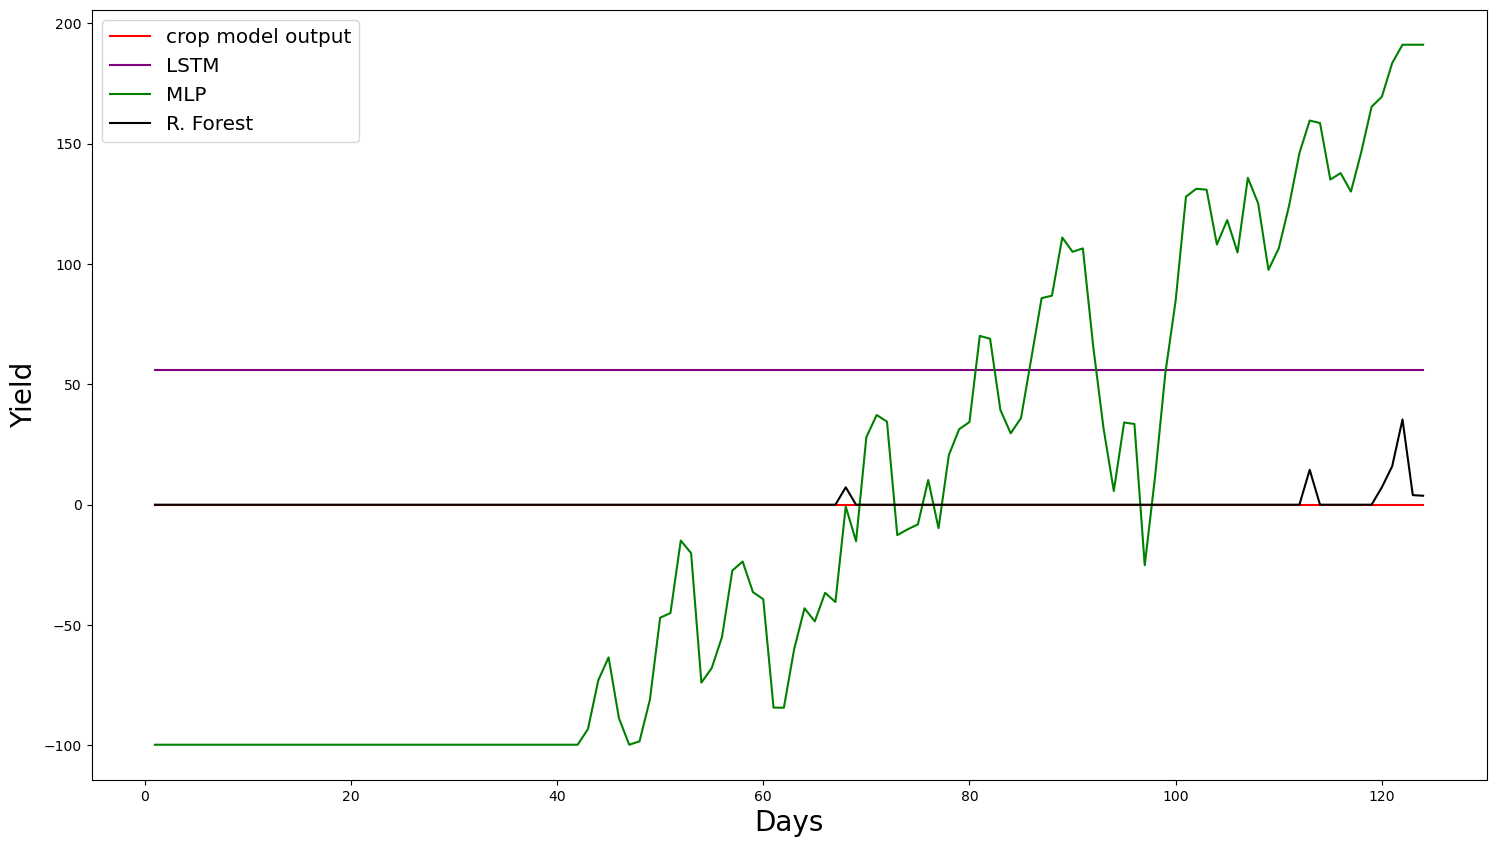

In [156]:
t_range = [i for i in range(1, 125)] 
plt.figure(figsize=(18, 10))
plt.plot(t_range, y_data[t_range], color='red', label="crop model output")
for name in predictions:
    inv_preds = y_scaler.inverse_transform(predictions[name].reshape((-1, 1))).reshape((1, -1))[0]
    plt.plot(t_range, inv_preds[t_range], color=colors[name], label=name)
plt.legend(fontsize="x-large")    
plt.xlabel('Days', fontsize=20)
plt.ylabel('Yield', fontsize=20)
plt.show

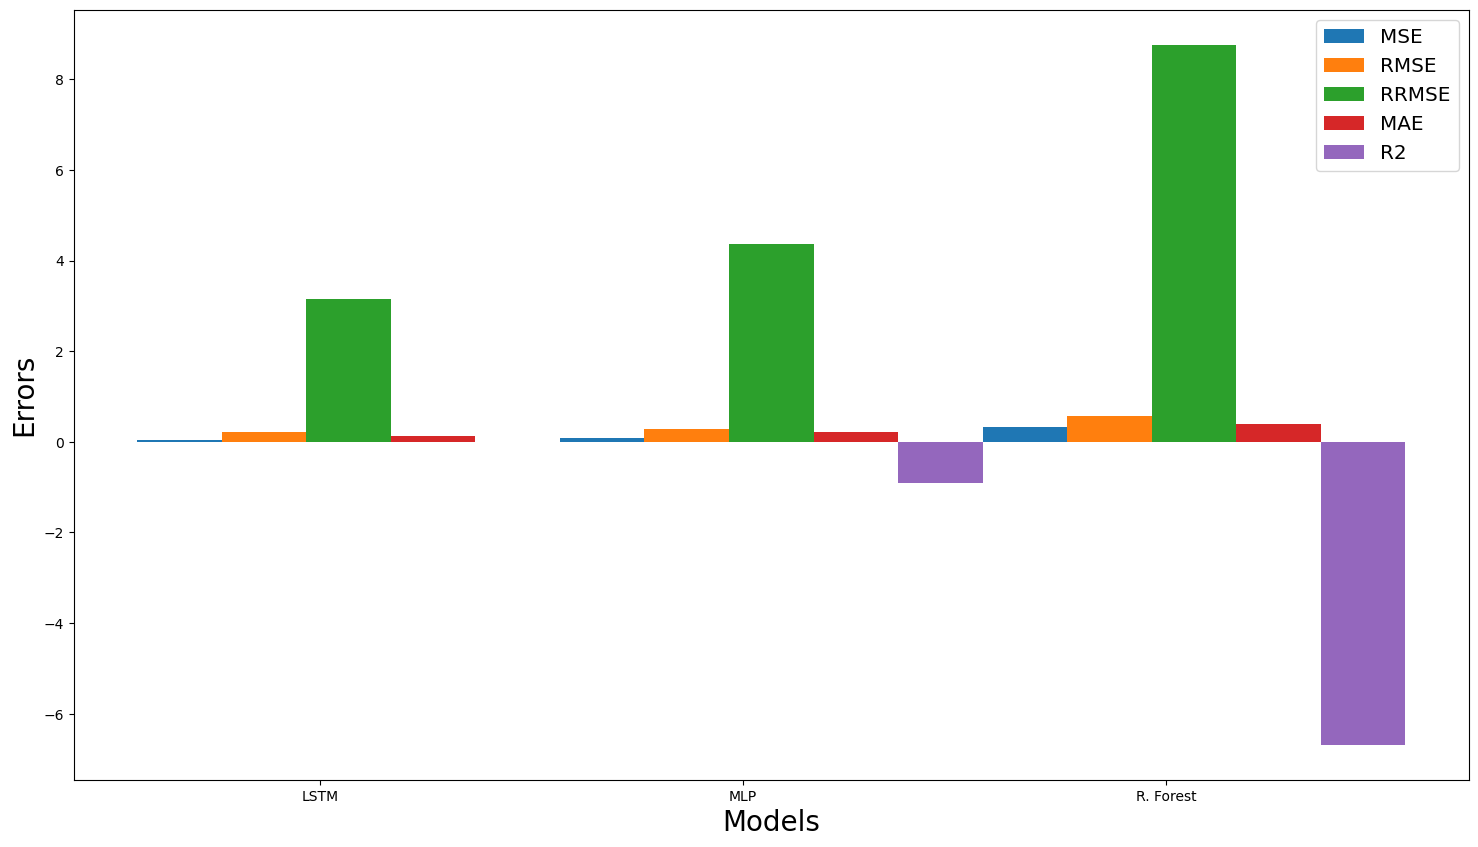

In [159]:
X_axis = np.arange(len(model_names))
plt.figure(figsize=(18, 10))
width = 0.2
r_width = 0
par = [par_mse, par_rmse, par_rrmse,par_mae, par_r2] 
for i, name in enumerate(performance_names):
    plt.bar(X_axis + r_width, par[i], width=width, label = name)
    r_width +=width
  
plt.xticks(X_axis+r_width/3, model_names)
plt.xlabel("Models", fontsize=20)
plt.ylabel("Errors", fontsize=20)
plt.legend(fontsize="x-large")
plt.show()